# Laden der Rohdaten

In [7]:
import pickle

# Laden der 'kirp' Liste aus der Pickle-Datei
with open('rick.pickle', 'rb') as f:
    data_frame = pickle.load(f)

# Aktiviere Cuda Support

In [8]:
import torch
device = "cpu"
if torch.cuda.is_available():
    print("CUDA is available on your system.")
    device = "cuda"
else:
    print("CUDA is not available on your system.")

CUDA is available on your system.


# PCA Klasse zu Reduktion der Dimensionen

In [9]:
from torch.utils.data import Dataset
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Dict


class GenomeDataset(Dataset):
    """
    Eine benutzerdefinierte Dataset-Klasse, die für die Handhabung von Genomdaten konzipiert ist.
    Diese Klasse wendet eine Principal Component Analysis (PCA) auf die Frequenzen der Genome an
    und teilt den Datensatz in Trainings- und Validierungsteile auf.

    Attributes:
        dataframe (pd.DataFrame): Ein Pandas DataFrame, der die initialen Daten enthält.
        train_df (pd.DataFrame): Ein DataFrame, der den Trainingsdatensatz nach der Anwendung von PCA und der Aufteilung enthält.
        val_df (pd.DataFrame): Ein DataFrame, der den Validierungsdatensatz nach der Anwendung von PCA und der Aufteilung enthält.

    Methods:
        __init__(self, dataframe, n_pca_components=1034, train_size=0.8, split_random_state=42):
            Konstruktor für die GenomeDataset Klasse.
        _do_PCA(self, frequencies, n_components=1034):
            Wendet PCA auf die gegebenen Frequenzen an.
        _split_dataset(self, train_size=0.8, random_state=42):
            Teilt den DataFrame in Trainings- und Validierungsdatensätze auf.
        __getitem__(self, index):
            Gibt ein Tupel aus transformierten Frequenzen und dem zugehörigen Krebstyp für einen gegebenen Index zurück.
        __len__(self):
            Gibt die Gesamtlänge der kombinierten Trainings- und Validierungsdatensätze zurück.
    """

    def __init__(self, dataframe: pd.DataFrame, n_pca_components: int = 1034, train_size: float = 0.8, split_random_state: int = 42):
        """
        Konstruktor für die GenomeDataset Klasse.

        Parameters:
            dataframe (pd.DataFrame): Der DataFrame, der die Genome Frequenzen und Krebsarten enthält.
            n_pca_components (int): Die Anzahl der PCA-Komponenten, auf die reduziert werden soll. Standardwert ist 1034.
            train_size (float): Der Anteil der Daten, der als Trainingsdaten verwendet werden soll. Standardwert ist 0.8.
            split_random_state (int): Der Zufalls-Saatwert, der für die Aufteilung des Datensatzes verwendet wird. Standardwert ist 42.
        """
        self.dataframe = dataframe

        # Umwandlung der Krebsarten in numerische Werte
        self.label_encoder = LabelEncoder()
        self.dataframe['encoded_cancer_type'] = self.label_encoder.fit_transform(dataframe['cancer_type'])

        # Anwenden der PCA auf die Frequenzen
        self.dataframe['pca_frequencies'] = self._do_PCA(self.dataframe['genome_frequencies'].tolist(), n_pca_components)

        # Teilen des DataFrame in Trainings- und Validierungsdatensatz
        self._split_dataset(train_size=train_size, random_state=split_random_state)

    def transform_datapoint(self, datapoint: List[float]) -> List[float]:
        """
        Transformiert einen einzelnen Datenpunkt durch Standardisierung und Anwendung der PCA.

        Diese Methode nimmt einen rohen Datenpunkt (eine Liste von Frequenzen), standardisiert ihn mit dem 
        zuvor angepassten Scaler und wendet dann die PCA-Transformation an, um ihn in den reduzierten 
        Feature-Raum zu überführen, der für das Training des Modells verwendet wurde.

        Parameters:
            datapoint (List[float]): Ein roher Datenpunkt, bestehend aus einer Liste von Frequenzen.

        Returns:
            List[float]: Der transformierte Datenpunkt, nach Anwendung der Standardisierung und der PCA.
        """
        # Standardisierung des Datenpunkts
        scaled_data_point = self.scaler.transform([datapoint])

        # PCA-Transformation des standardisierten Datenpunkts
        pca_transformed_point = self.pca.transform(scaled_data_point)

        return pca_transformed_point.tolist()

    def _do_PCA(self, frequencies: List[List[float]], n_components: int = 1034) -> List[List[float]]:
        """
        Wendet PCA auf die gegebenen Frequenzen an.

        Parameters:
            frequencies (List[List[float]]): Die Liste der Frequenzen, auf die die PCA angewendet werden soll.
            n_components (int): Die Anzahl der Komponenten für die PCA. Standardwert ist 1034.

        Returns:
            List[List[float]]: Eine Liste von Listen, die die transformierten Frequenzen nach der PCA darstellt.
        """

        # Standardisieren der Frequenzen
        self.scaler = StandardScaler()
        scaled_frequencies = self.scaler.fit_transform(frequencies)

        # PCA-Instanz erstellen und auf die gewünschte Anzahl von Komponenten reduzieren
        self.pca = PCA(n_components=n_components)

        # PCA auf die Frequenzen anwenden
        pca_result = self.pca.fit_transform(scaled_frequencies)

        return pca_result.tolist()

    def _split_dataset(self, train_size: float = 0.8, random_state: int = 42):
        """
        Teilt den DataFrame in Trainings- und Validierungsdatensätze auf.

        Parameters:
            train_size (float): Der Anteil der Daten, der als Trainingsdaten verwendet werden soll.
            random_state (int): Der Zufalls-Saatwert, der für die Aufteilung des Datensatzes verwendet wird.
        """

        class SplittedDataset(Dataset):
            def __init__(self, dataframe):
                self.dataframe = dataframe

                # Umwandlung der Genome Frequenzen in Tensoren
                self.genome_frequencies = torch.tensor(dataframe['pca_frequencies'].tolist(), dtype=torch.float32)

                # Umwandlung der Krebsarten in numerische Werte
                self.label_encoder = LabelEncoder()
                self.cancer_types = torch.tensor(dataframe['encoded_cancer_type'].tolist(), dtype=torch.long)

            def __getitem__(self, index):
                # Rückgabe eines Tupels aus Genome Frequenzen und dem entsprechenden Krebstyp
                return self.genome_frequencies[index], self.cancer_types[index]

            def __len__(self):
                return len(self.dataframe)

        # Teilen des DataFrame in Trainings- und Validierungsdatensatz
        train_df, val_df = train_test_split(self.dataframe, train_size=train_size) #, random_state=random_state)
        self.train_df = SplittedDataset(train_df)
        self.val_df = SplittedDataset(val_df)


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Gibt ein Tupel aus transformierten Frequenzen und dem entsprechenden Krebstyp für einen gegebenen Index zurück.

        Parameters:
            index (int): Der Index des zu abrufenden Datenelements.

        Returns:
            Tuple[torch.Tensor, int]: Ein Tupel, bestehend aus einem Tensor der transformierten Frequenzen und dem zugehörigen Krebstyp.
        """

        print(self.train_df.shape)
        print(self.val_df.shape)
        
        if index < len(self.train_df):
            row = self.train_df.iloc[index]
        else:
            row = self.val_df.iloc[len(self.train_df) - index]

        pca_frequencies_tensor = torch.tensor(row['pca_frequencies'], dtype=torch.float32)
        cancer_type = row['encoded_cancer_type']

        return pca_frequencies_tensor, cancer_type

    def __len__(self) -> int:
        """
        Gibt die Gesamtlänge der kombinierten Trainings- und Validierungsdatensätze zurück.

        Returns:
            int: Die Länge der kombinierten Datensätze.
        """
        
        return len(self.train_df) + len(self.val_df)


# Definition des neuronalen Netzes

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CancerClassifierNN(nn.Module):
    """
    Eine benutzerdefinierte neuronale Netzwerkklassifikator-Klasse für die Krebsklassifikation.

    Diese Klasse definiert ein mehrschichtiges Perzeptron (MLP), das für die Klassifizierung von Krebsarten
    anhand genetischer Frequenzdaten verwendet wird.

    Attributes:
        fc1 (nn.Linear): Die erste lineare Schicht des Netzwerks.
        fc2 (nn.Linear): Die zweite lineare Schicht des Netzwerks.
        fc3 (nn.Linear): Die dritte lineare Schicht des Netzwerks.
        fc4 (nn.Linear): Die Ausgabeschicht des Netzwerks.
        dropout (nn.Dropout): Ein Dropout-Layer zur Vermeidung von Overfitting.

    Methods:
        __init__(self, input_size: int, num_classes: int):
            Konstruktor für die CancerClassifierNN Klasse.
        forward(self, x: torch.Tensor) -> torch.Tensor:
            Definiert den Vorwärtsdurchlauf des Netzwerks.
    """

    def __init__(self, input_size: int, num_classes: int):
        """
        Konstruktor für die CancerClassifierNN Klasse.

        Parameters:
            input_size (int): Die Größe des Input-Features.
            num_classes (int): Die Anzahl der Zielklassen.
        """
        super(CancerClassifierNN, self).__init__()
        # Definieren der Schichten
        self.fc1 = nn.Linear(input_size, input_size)  # Eingabeschicht
        self.fc2 = nn.Linear(input_size, input_size//2)        # Versteckte Schicht
        self.fc3 = nn.Linear(input_size//2, input_size//4)         # Weitere versteckte Schicht
        self.fc4 = nn.Linear(input_size//4, num_classes) # Ausgabeschicht
        self.dropout = nn.Dropout(p=0.5)       # Dropout

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Definiert den Vorwärtsdurchlauf des Netzwerks.

        Parameters:
            x (torch.Tensor): Der Input-Tensor für das Netzwerk.

        Returns:
            torch.Tensor: Der Output-Tensor nach dem Durchlauf durch das Netzwerk.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc4(x), dim=1)  # Oder F.log_softmax(x, dim=1) für Mehrklassenklassifikation
        return x

In [11]:
from torch.utils.data import DataLoader
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

class ExperimentationalExperiments():

    def __init__(self) -> None:
        self.results = None

    def run_single_experiment(self, train_loader: DataLoader, valid_loader: DataLoader, n_pca_components: int, n_epochs: int = 200, learning_rate: int = 0.0005, verbose: bool = True, experiment_num: int = None) -> Tuple:
        if not isinstance(n_pca_components, int):
            raise TypeError("n_pca_components must be an integers!")

        model = CancerClassifierNN(input_size=n_pca_components, num_classes=3)
        model.to(device=device)

        # Verlustfunktion
        criterion = nn.CrossEntropyLoss()
        # Optimierer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Listen, um Verluste zu speichern
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []

        for epoch in range(n_epochs):
            model.train()
            train_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Berechnen der Genauigkeit
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

            # Durchschnittlicher Trainingsverlust und Genauigkeit
            train_loss /= len(train_loader)
            train_accuracy = correct_predictions / total_predictions
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validierungsverlust und Genauigkeit
            model.eval()
            valid_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()

                    # Berechnen der Genauigkeit
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()
                    total_predictions += labels.size(0)

            # Durchschnittlicher Validierungsverlust und Genauigkeit
            valid_loss /= len(valid_loader)
            valid_accuracy = correct_predictions / total_predictions
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

            if valid_accuracy >= 0.999:
                break


            # Aktualisieren des Graphen
            clear_output(wait=True)
            fig, ax1 = plt.subplots()

            # Zeichnen der Verlustkurven
            ax1.plot(train_losses, label='Trainingsverlust', color='r')
            ax1.plot(valid_losses, label='Validierungsverlust', color='b')
            ax1.set_xlabel('Epochen')
            ax1.set_ylabel('Verlust', color='g')
            ax1.tick_params(axis='y', labelcolor='g')

            # Zweite y-Achse für die Genauigkeit
            ax2 = ax1.twinx()
            ax2.plot(train_accuracies, label='Trainingsgenauigkeit', color='r', linestyle='dashed')
            ax2.plot(valid_accuracies, label='Validierungsgenauigkeit', color='b', linestyle='dashed')
            ax2.set_ylabel('Genauigkeit', color='g')
            ax2.tick_params(axis='y', labelcolor='g')

            # Titel und Legende
            plt.title(f'Experiment #{experiment_num}: Trainings- und Validierungsverlust und -genauigkeit über die Zeit mit \n{n_pca_components}-Hauptkomponenten, Lernrate: {learning_rate}')
            fig.tight_layout()

            # Legende außerhalb des Graphen
            ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
            ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

            # Fortschritt anzeigen, falls angegeben
            if verbose:
                # Plot speichern
                name = str(experiment_num) + ".png" if experiment_num is not None else "single_experiment.png"
                if not os.path.exists("Experiments"):
                    os.makedirs("Experiments")
                if not os.path.exists(f"Experiments/{str(n_pca_components)}"):
                    os.makedirs(f"Experiments/{str(n_pca_components)}")
                plt.savefig(f"Experiments/{str(n_pca_components)}/{name}")

                plt.show()
                print(f'Epoch [{epoch+1}/{n_epochs}], Trainingsverlust: {train_loss:.4f}, Trainingsgenauigkeit: {train_accuracies[-1]:.4f}, Validierungsverlust: {valid_loss:.4f}, Validierungsgenauigkeit: {valid_accuracies[-1]:.4f}')

        return train_losses, valid_losses, train_accuracies, valid_accuracies

    def run_single_pca_experiment(self, train_loader: DataLoader, valid_loader: DataLoader, n_pca_components: int, n_experiments: int, n_epochs: int = 200, learning_rate: int = 0.0005, verbose: bool = True) -> List:
        if not isinstance(n_pca_components, int):
            raise TypeError("n_pca_components must be an integers!")

        results = []

        for n in range(n_experiments):
            res = self.run_single_experiment(train_loader, valid_loader, n_pca_components, n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose, experiment_num=n+1)
            results.append(res)

        return results
            

    def run(self, n_pca_components: List[int], n_experiments: int, n_epochs: int = 200, learning_rate: int = 0.0005, batch_size: int = 64, verbose: bool = True) -> Dict:
        if not isinstance(n_pca_components, list):
            raise TypeError("n_pca_components must be a list of integers!")

        self.n_pca_components = n_pca_components

        results = {}

        for n_pca_comps in n_pca_components:
            genome_dataset = GenomeDataset(data_frame, n_pca_components=n_pca_comps)
            train_dataset = genome_dataset.train_df
            valid_dataset = genome_dataset.val_df

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

            res = self.run_single_pca_experiment(train_loader, valid_loader, n_pca_comps, n_experiments, n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose)
            results[str(n_pca_comps)] = res

            self.plot_and_save_results(res, n_pca_comps)

        self.results = results

        return results

    def plot_and_save_results(self, results: List[Tuple], n_pca_components: int) -> None:
        # Mittelwerte und Standardabweichungen berechnen
        train_losses, valid_losses, train_accuracies, valid_accuracies = zip(*results)

        train_losses = np.array(train_losses)
        valid_losses = np.array(valid_losses)
        train_accuracies = np.array(train_accuracies)
        valid_accuracies = np.array(valid_accuracies)

        avg_train_losses = np.mean(train_losses, axis=0)
        avg_valid_losses = np.mean(valid_losses, axis=0)
        avg_train_acc = np.mean(train_accuracies, axis=0)
        avg_valid_acc = np.mean(valid_accuracies, axis=0)

        std_train_losses = np.std(train_losses, axis=0)
        std_valid_losses = np.std(valid_losses, axis=0)
        std_train_acc = np.std(train_accuracies, axis=0)
        std_valid_acc = np.std(valid_accuracies, axis=0)

        # Erstellen von Plots
        epochs = range(1, len(avg_train_losses) + 1)

        # Plot für Verluste
        plt.plot(epochs, avg_train_losses, label='Mittlerer Trainingsverlust', color='r')
        plt.fill_between(epochs, np.subtract(avg_train_losses, std_train_losses), np.add(avg_train_losses, std_train_losses), color='r', alpha=0.2)
        plt.plot(epochs, avg_valid_losses, label='Mittlerer Validierungsverlust', color='b')
        plt.fill_between(epochs, np.subtract(avg_valid_losses, std_valid_losses), np.add(avg_valid_losses, std_valid_losses), color='b', alpha=0.2)
        plt.title(f'Mittelwert und Standardabweichung der Verluste für {n_pca_components} PCA-Komponenten')
        plt.xlabel('Experiment Nummer')
        plt.ylabel('Verlust')
        plt.legend()
        plt.savefig(f"Experiments/{n_pca_components}/average_losses.png")
        plt.clf()

        # Plot für Genauigkeiten
        plt.plot(epochs, avg_train_acc, label='Mittlere Trainingsgenauigkeit', color='r')
        plt.fill_between(epochs, np.subtract(avg_train_acc, std_train_acc), np.add(avg_train_acc, std_train_acc), color='r', alpha=0.2)
        plt.plot(epochs, avg_valid_acc, label='Mittlere Validierungsgenauigkeit', color='b')
        plt.fill_between(epochs, np.subtract(avg_valid_acc, std_valid_acc), np.add(avg_valid_acc, std_valid_acc), color='b', alpha=0.2)
        plt.title(f'Mittelwert und Standardabweichung der Genauigkeiten für {n_pca_components} PCA-Komponenten')
        plt.xlabel('Experiment Nummer')
        plt.ylabel('Genauigkeit')
        plt.legend()
        plt.savefig(f"Experiments/{n_pca_components}/average_accuracies.png")
        plt.clf()

        

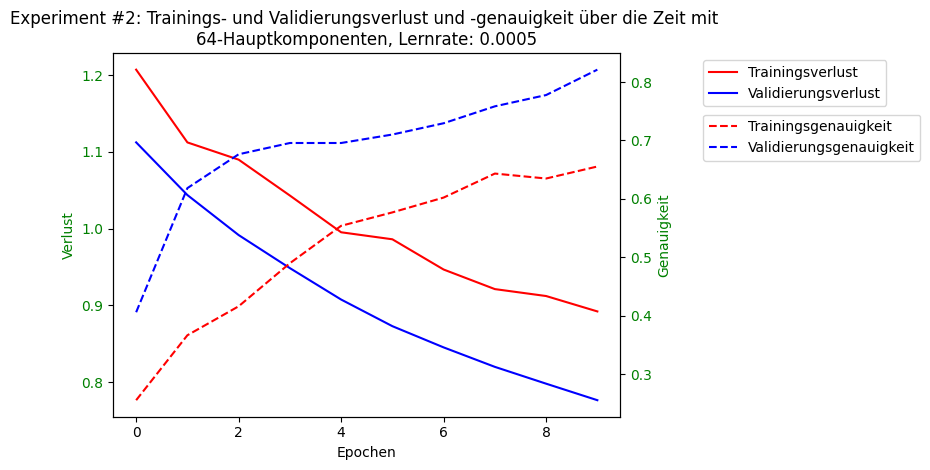

Epoch [10/10], Trainingsverlust: 0.8922, Trainingsgenauigkeit: 0.6554, Validierungsverlust: 0.7765, Validierungsgenauigkeit: 0.8213


{'128': [([1.1048660278320312,
    1.0021918095075166,
    0.9533032820774958,
    0.9180488632275507,
    0.8890538536585294,
    0.8560153337625357,
    0.8325601586928735,
    0.7921991394116328,
    0.7684880128273597,
    0.7482978334793677],
   [1.0328907370567322,
    0.9768994599580765,
    0.9316655248403549,
    0.8864333480596542,
    0.8357236087322235,
    0.7867822349071503,
    0.7491058260202408,
    0.7292499840259552,
    0.7173636108636856,
    0.7077213227748871],
   [0.3808948004836759,
    0.5646916565900847,
    0.6178960096735188,
    0.6360338573155986,
    0.660217654171705,
    0.6856106408706167,
    0.7267230955259976,
    0.7678355501813785,
    0.7980652962515115,
    0.8089480048367593],
   [0.5603864734299517,
    0.5603864734299517,
    0.5700483091787439,
    0.6280193236714976,
    0.7342995169082126,
    0.7874396135265701,
    0.7971014492753623,
    0.8115942028985508,
    0.8309178743961353,
    0.8454106280193237]),
  ([1.07738203727282,
    0.9

<Figure size 640x480 with 0 Axes>

In [12]:
e = ExperimentationalExperiments()
e.run([1024, 512, 256, 128, 64, 32, 16], 10, n_epochs=500)